In [160]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import math
import random
import pickle
import copy

In [161]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg']

n_class = len(labels)

In [162]:
t = time.time()

# Load preprocessed data
train_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_data.bp')
train_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_labels.bp')
train_kernel = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_spm_dist_mat.bp')
train_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_fnames.bp')

test_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_data.bp')
test_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_labels.bp')
test_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_fnames.bp')

sys.stderr.write('Load time: %f seconds\n' % (time.time() - t)) # ~ 2s / 12k training data

Load time: 0.229030 seconds


In [163]:
print train_X.shape
print train_kernel.shape
print test_X.shape

(2763, 4200)
(2763, 2763)
(691, 4200)


In [164]:
class Hypersphere_abstain:
    
    def __init__(self, center, radius, threshold, label, alpha, beta, D, err, weighted_err, unweighted_err,
                 label_confidences, label_distribution, center_index, neighbor_indices, d_var, max_q_var):
        
        self.center = center
        self.radius = radius
        self.thres = threshold
        self.label = label
        self.alpha = alpha
        self.beta = beta
        self.D = D 
        self.pseudo_err = err # PSEUDO error
        self.weighted_err = weighted_err
        self.unweighted_err = unweighted_err
        self.label_confidences = label_confidences
        self.label_distribution = label_distribution
        self.center_index = center_index
        self.neighbor_indices = neighbor_indices
        
        # Hack
        self.d_var = d_var
        self.max_q_var = max_q_var
        
class WeakLearner_generator:
    
    def __init__(self, init_radius, growth_radius, end_radius, abstain_thres, err_thres):
        
        self.init_radius = init_radius
        self.growth_radius = growth_radius
        self.end_radius = end_radius
        self.abstain_thres = abstain_thres
        self.err_thres = err_thres
        
    def generate_pseudo(self, train_X, train_y, train_kernel, D, Q, mask, n_class):
        
        n_samples = train_X.shape[0]
        D = D.reshape((n_samples, ))

        # Choose an exemplar
        exemplar_index = np.random.choice(range(n_samples), p=D.tolist())
        exemplar = train_X[exemplar_index]

        # Retrieve scores to exemplar and sort
        scores = train_kernel[exemplar_index]
        sorted_scores = np.sort(scores)[::-1]
        sorted_indices = np.argsort(scores)[::-1]
        sorted_y = train_y[sorted_indices].astype('int64')
        sorted_D = D[sorted_indices]
        sorted_Q = Q[sorted_indices]
        sorted_mask = mask[sorted_indices]
        
        # Calculate plurarity and percentage of initial sphere
        init_size = np.argmax(sorted_scores<self.init_radius)
        count = np.bincount(sorted_y[:init_size],
                            weights=sorted_D[:init_size],
                            minlength=n_class)
        unweighted_count = np.bincount(sorted_y[:init_size],
                                       minlength=n_class)
        y_of_interest = np.argmax(count)
        percentage = count[y_of_interest]*1.0 / np.sum(sorted_D[:init_size])

        # Abstain test (HACK to avoid zero threshold)
        if np.sum(sorted_scores)==0.0:
            return None, None
        
        # Calculate cumulative weight sums
        sorted_D_tile = np.tile(sorted_D.reshape((n_samples,1)), (1, n_class))
        label_D_cum = np.cumsum(sorted_D_tile*sorted_mask, axis=0)
        label_Dq_cum = np.cumsum(sorted_D_tile*~sorted_mask*sorted_Q, axis=0)

        # Hypothesis and pseudo loss
#         radii = range(self.init_radius, n_samples, self.growth_radius)
#         radii = [self.init_radius*10]
#         radii = [n_samples]
        radii = np.arange(self.end_radius, self.init_radius+self.growth_radius, self.growth_radius)[::-1]
        hypo = np.zeros((len(radii), n_class), dtype=bool)
        pseudo_loss = np.zeros((len(radii),1))
        
        # For each radius
        for c,r in enumerate(radii):
            
            i = np.argmax(sorted_scores<r)
            
            # Calculate best hypotheses
            deriv = -1.0*label_D_cum[i-1]+label_Dq_cum[i-1]
            hypo[c] = (deriv<0.0).astype('float')
            label_conf = np.tile(hypo[c], (n_samples, 1))
#             print 'Sizes: ', hypo[c].shape, label_conf.shape
    
            # Calculate three terms in pseudo loss
            ones_term = np.ones((n_samples,1)).astype('float')
            label_term = np.sum(sorted_mask*label_conf, axis=1).reshape((n_samples,1)).astype('float')
            nonlabel_sum = np.sum(~sorted_mask*sorted_Q*label_conf, axis=1).reshape((n_samples,1)).astype('float')
            
            # Calculate pseudo loss
            pseudo_loss[c] = 0.5 * np.sum(sorted_D[:i].reshape((i,1))*(ones_term[:i] - label_term[:i] + nonlabel_sum[:i]))
            pseudo_loss[c] += 0.5 * np.sum(sorted_D[i:])
#             print '(Radius, Samples, P_loss): ', (r, i, pseudo_loss[c])
#             print 'sorted_D: ', sorted_D[:]
#             print 'Ones_term: ', ones_term[:]
#             print 'Label_term: ', label_term[:20]
#             print 'Nonlabel_term: ', nonlabel_sum[:20]
#             print 'Combined: ', (ones_term - label_term + nonlabel_sum)[:20]
#             print 'Calc: ', (sorted_D.reshape((n_samples,1))*(ones_term - label_term + nonlabel_sum))[:20]
#             print 'Sum: ', np.sum(sorted_D.reshape((n_samples,1))*(ones_term - label_term + nonlabel_sum))
            
            
        # Calculate best radius
        best_idx = np.argmin(pseudo_loss)
        best_radius = np.argmax(sorted_scores<radii[best_idx])
        
        # Prediction by best radius hypothesis
        label_conf = hypo[best_idx]
        p_err = pseudo_loss[best_idx]
#         print 'BEST RADIUS: ', best_radius
        
        if random.random()<0.025:
            print 'BEST (Size, Ploss, Hypo): ', (best_radius, list(p_err), list(label_conf.astype('int')))

        # Calculate label distritbution
        label_distribution = np.bincount(sorted_y[:best_radius], minlength=n_class)
    
        # Error test
        if p_err>self.err_thres:
            return None, None
        
        # Calculate alpha
        epsilon = 1.0e-24
        alpha = math.log((1.0-p_err+epsilon)/(p_err+epsilon))
        beta = (p_err+epsilon)*1.0/(1.0-p_err-epsilon)

        # Return weakleaner
        err = 0.0
        w_err = 0.0
        threshold = sorted_scores[best_radius-1]
        
        d_var = np.var(D)
        max_q_var= np.max(np.var(sorted_Q, axis=1))
        
        h = Hypersphere_abstain(exemplar, best_radius, threshold, y_of_interest,
                                alpha, beta, D, p_err, w_err, err, label_conf, label_distribution,
                                exemplar_index, sorted_indices, d_var, max_q_var)
        
        return h, sorted_mask
    

In [165]:
# Adaboost.M2

class Adaboost_M2:
    
    def __init__(self, iterations, n_class, weaklearner):
        
        self.T = iterations
        self.H = []
        self.D = None
        self.Q = None
        self.W = None
        self.W_staged = [] #Hack
        self.label_mask = None
        self.n_class = n_class
        self.weaklearner = weaklearner
    
    def train(self, train_X, train_y, train_kernel):
        
        n_samples = train_X.shape[0]
        
        # Create column mask for weights
        rows = list(xrange(n_samples))
        cols = train_y.astype('int64').tolist()
        self.label_mask = np.zeros((n_samples, self.n_class), dtype=bool)
        self.label_mask[rows, cols] = True
        
        # Initialize weights
        self.D = np.ones((n_samples, 1))*(1.0/n_samples)
        self.W = np.zeros((n_samples, self.n_class)) + \
                    ~self.label_mask*np.tile(self.D, (1,n_class))*(1.0/(self.n_class-1))
#         W_sum = np.sum(self.W, axis=1).reshape((n_samples,1))
#         self.Q = np.zeros((n_samples, self.n_class)) + \
#                     self.W*1.0/np.tile(W_sum,(1,self.n_class))
#         self.D = W_sum*1.0/np.sum(W_sum)

        for t in xrange(self.T):

            if t%100==0:
                print 't: ', t
                
            # Normalize
            W_sum = np.sum(self.W, axis=1).reshape((n_samples,1))
            self.Q = np.zeros((n_samples, self.n_class)) + \
                        self.W*1.0/np.tile(W_sum,(1,self.n_class))
            self.D = W_sum*1.0/np.sum(W_sum)
#             print 'Sizes: ', (self.D.shape, self.Q.shape, self.W.shape, W_sum.shape)
#             print 'D_sum: ', np.sum(self.D)
#             print 'Q_sum: ', np.sum(self.Q*~self.label_mask, axis=1)
#             print 'Q_sum_sum: ', np.sum(np.sum(self.Q*~self.label_mask, axis=1))
#             print '~Q_sum: ', np.sum(np.sum(self.Q*self.label_mask, axis=1))
#             print 'W_sum==D? ', W_sum==self.D

#             Q_sample_sum = np.sum(self.Q, axis=1).reshape((n_samples, 1))
#             self.Q = self.Q / Q_sample_sum
#             self.D = Q_sample_sum / np.sum(Q_sample_sum)
#             print 'h: ', h.label_confidences.astype('int')
#             print 'Q: ', self.Q[:10,:]
#             print 'Q_sum: ', Q_sample_sum[:20]
            
            # Generate weaklearner
            h, h_neighbor_label_mask = \
                self.weaklearner.generate_pseudo(train_X, train_y, train_kernel, self.D, self.Q, self.label_mask, self.n_class)
            
            # Check abstained
            if not h:
                continue
                
            self.H.append(h)

            # Reweight
            base_term = h.beta*np.ones((n_samples, self.n_class))
            ones_term = np.ones((n_samples, self.n_class)).astype('float')
            label_weights = np.tile(h.label_confidences.reshape((1, self.n_class)), (n_samples, 1))
            label_term = np.sum(h_neighbor_label_mask*label_weights, axis=1).reshape((n_samples, 1))
            label_term = np.tile(label_term, ((1, self.n_class))).astype('float')
            nonlabel_term = ~h_neighbor_label_mask*label_weights.astype('float')
            
            power_term = 0.5*(ones_term + label_term - nonlabel_term)
            
            neighbors_in_sphere = h.neighbor_indices[:h.radius]
            neighbors_out_sphere = h.neighbor_indices[h.radius:]
#             self.Q[neighbors_in_sphere] = self.Q[neighbors_in_sphere] * \
#                                             np.power(base_term[:h.radius], power_term[:h.radius])
#             self.Q[neighbors_out_sphere] = self.Q[neighbors_out_sphere] * \
#                                             np.power(base_term[h.radius:], 0.5*ones_term[h.radius:])


            prev_W = copy.deepcopy(self.W)
    
#             print 'W[neighbors_in_sphere]: ', self.W[neighbors_in_sphere]
#             print 'W[neighbors_out_sphere]: ', self.W[neighbors_out_sphere]
    
            self.W[neighbors_in_sphere] = self.W[neighbors_in_sphere] * \
                                            np.power(base_term[:h.radius], power_term[:h.radius])
            self.W[neighbors_out_sphere] = self.W[neighbors_out_sphere] * \
                                            np.power(base_term[h.radius:], 0.5*ones_term[h.radius:])
        
#             print 'W_shape: ', self.W.shape
#             print 'neighbors_in_sphere: ', neighbors_in_sphere
#             print 'W[neighbors_in_sphere]: ', self.W[neighbors_in_sphere]
#             print 'W[neighbors_in_sphere].shape: ', self.W[neighbors_in_sphere].shape
#             print 'neighbors_out_sphere: ', neighbors_out_sphere
#             print 'W[neighbors_out_sphere]: ', self.W[neighbors_out_sphere]
#             print 'W[neighbors_out_sphere].shape: ', self.W[neighbors_out_sphere].shape
#             print 'Base_term: ', base_term
            
#             print 'Beta: ', h.beta
            
#             print 'h_label_mask: ', h_neighbor_label_mask
#             print 'h_label_mask.shape: ', h_neighbor_label_mask.shape
#             print 'h_label_mask==True: ', np.sum(np.sum(h_neighbor_label_mask==True))
#             print 'Label_weights: ', label_weights
#             print 'Label_term: '#, label_term
#             for sample in label_term:
#                 print '\t', sample[:]
#             print 'Nonlabel_term: '#, nonlabel_term
#             for sample in nonlabel_term:
#                 print '\t', sample[:]
#             print 'Power_term: '#, power_term
#             for sample in power_term:
#                 print '\t', sample[:]
#             print 'Neighbor Factor: '#, np.power(base_term[:h.radius], power_term[:h.radius])
#             for sample in np.power(base_term[:h.radius], power_term[:h.radius]):
#                 print '\t', sample[:] 
#             print 'Non-Neighbor Factor: '#, np.power(base_term[:h.radius], power_term[:h.radius])
#             for sample in np.power(base_term[h.radius:], 0.5*ones_term[h.radius:]):
#                 print '\t', sample[:]
            
#             print 'Diff: ', np.sum(np.sum(self.W*1.0-prev_W*1.0))
            self.W_staged.append(self.W)
            
#         print 'Q_sum: \n', Q_sample_sum[:20]
        print 'Num classifiers: ', len(self.H)

    def predict(self, train_X, train_y, train_kernel=None):

        no_kernel = train_kernel==None
        n_samples = train_X.shape[0]
        cumulative_prob = np.zeros((n_samples, self.n_class)).astype('float')
        staged_pred_y = np.zeros((len(self.H), n_samples)).astype('int64')
#         print 'n: ', n_samples
        
        if no_kernel:
            
            def compute_intersection_kernel_oneJob(i):
                dist = np.minimum(self.H[i].center, test_X)
                dist = np.sum(dist, axis=1).reshape((1, n_samples))
                return dist
            
            score_kernel = np.concatenate([compute_intersection_kernel_oneJob(i) for i in xrange(len(self.H))], axis=0)
            print 'Test kernel shape: ', score_kernel.shape
            
        else:
            score_kernel = None

        for i in xrange(len(self.H)):
            
            clf = self.H[i]
            
            score = np.copy(score_kernel[i]) if no_kernel else np.copy(train_kernel[clf.center_index])
            score[score < clf.thres] = 0.0 #Abstain
            score[score >= clf.thres] = math.log(1.0/clf.beta)
            
            label_weights = clf.label_confidences.astype('float')
            cumulative_prob += np.multiply(score.reshape((n_samples,1)), label_weights.reshape((1,self.n_class)))
            
#             print 'Radius: ', clf.radius
#             print 'Threshold: ', clf.thres
#             print 'Hypo: ', clf.label_confidences
#             print 'Score Vector: ', score
#             print 'CUR_SCORES: ', np.multiply(score.reshape((n_samples,1)), label_weights.reshape((1,self.n_class)))
            
#             if i%50==0:
#                 print i, clf.radius,
#                 print 'Threshold: ', clf.thres
#                 print 'Abstained: ', np.sum(score==0.0),
#                 print 'Score==0: ', np.sum(np.sum(np.multiply(score.reshape((n_samples,1)), label_weights.reshape((1,self.n_class))), axis=1)==0),
#                 print 'Beta: ', clf.beta,
#                 print 'Label: ', clf.label
#                 print 'Hypo: ', clf.label_confidences.astype('int')
#                 print 'Cumulative: \n', cumulative_prob[:5,:5]
                
            max_prob = np.max(cumulative_prob, axis=1)
            pred_y = np.argmax(cumulative_prob, axis=1)
            pred_y[max_prob==0.0] = 0
            staged_pred_y[i,:] = pred_y
        
        print 'Correct predictions: ', np.sum(train_y==staged_pred_y[-1])
        
        return staged_pred_y


In [166]:
t = time.time()

# Setup
weak = WeakLearner_generator(init_radius=0.5,
                             growth_radius=0.05,
                             end_radius=0.2,
                             abstain_thres=0.5,
                             err_thres=1.0)
ada = Adaboost_M2(iterations=5000, 
                  n_class=n_class, 
                  weaklearner=weak)

sys.stderr.write('Setup time: %f seconds\n' % (time.time() - t)) # ~ 2s / 12k training data

Setup time: 0.025213 seconds


In [167]:
# Train

t = time.time()
ada.train(train_X, train_y, train_kernel)
sys.stderr.write('Train time: %f seconds\n' % (time.time() - t)) # ~ 15s / 12k training data

t:  0
BEST (Size, Ploss, Hypo):  (613, [0.48273578483744017], [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0])
t:  100
t:  200
BEST (Size, Ploss, Hypo):  (1260, [0.4915966051940589], [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1])
BEST (Size, Ploss, Hypo):  (761, [0.48684451130536521], [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1])
BEST (Size, Ploss, Hypo):  (1638, [0.48984530029955609], [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0])
BEST (Size, Ploss, Hypo):  (1891, [0.49098483940863707], [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0])
BEST (Size, Ploss, Hypo):  (478, [0.48696593335630656], [1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1])
BEST (Size, Ploss, Hypo):  (329, [0.49084047160749422], [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1])
t:  300
BEST (Size, Ploss, Hypo):  (2249, [0.49006707862362303], [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0])
BEST (Size, Ploss, Hypo):  (655, [0.49154942984464833], [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0])
BEST (Size, Ploss, Hypo):  (1534, [0.48848731983720206], [0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0])
BEST (Size, Ploss, Hypo): 

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in double_scalars
Train time: 52.278432 seconds


 4699


In [168]:
# Predict Train
staged_pred_y = ada.predict(train_X, train_y, train_kernel)

# Predict Test
staged_pred_y_test = ada.predict(test_X, test_y)

# Calculate true positive and abstain rate
t = len(staged_pred_y)-1
pred_y = staged_pred_y[-1]
n_training = staged_pred_y.shape[1]
n_abstain = np.sum(pred_y==0)
n_correct = np.sum(pred_y==train_y)
train_acc = (1.0 * n_correct / n_training)
train_abstain_rate = (1.0 * n_abstain / n_training)
train_wacc = (np.sum((pred_y==train_y)*ada.H[t].D)*1.0/np.sum(ada.H[t].D))

n_testing = staged_pred_y_test.shape[1]
pred_y = staged_pred_y_test[-1]
n_abstain = np.sum(pred_y==0)
n_correct = np.sum(pred_y==test_y)
test_acc = (1.0 * n_correct / n_testing)
test_abstain_rate = (1.0 * n_abstain / n_testing)

print ''
print 'Training: ', n_training
print 'Final Accuracy: ', train_acc
print 'Weighted Accuracy: ', train_wacc
print 'Abstain Rate: ', train_abstain_rate
print 'Testing: ', n_testing
print 'Final Accuracy: ', test_acc
print 'Abstain Rate: ', test_abstain_rate
print ''

Correct predictions:  1838
Test kernel shape:  (4699, 691)
Correct predictions:  373

Training:  2763
Final Accuracy:  0.665218964893
Weighted Accuracy:  0.516260711966
Abstain Rate:  0.0763662685487
Testing:  691
Final Accuracy:  0.53979739508
Abstain Rate:  0.0767004341534



/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:132: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [169]:
# # Parameter
# import itertools
# i_rad = [0.5, 0.4, 0.3]
# e_rad = [0.4, 0.3, 0.2, 0.1]
# rad = [(i,e) for (i,e) in itertools.product(i_rad, e_rad) if i>e]
# print rad, '\n'

# for (i,e) in rad:
    
#     tim = time.time()
    
#     # Setup
#     weak = WeakLearner_generator(init_radius=i,
#                                  growth_radius=0.05,
#                                  end_radius=e,
#                                  abstain_thres=0.5,
#                                  err_thres=1.0)
#     ada = Adaboost_M2(iterations=1000, 
#                       n_class=n_class, 
#                       weaklearner=weak)
    
#     # Train
#     ada.train(train_X, train_y, train_kernel)
    
#     # Predict Train
#     staged_pred_y = ada.predict(train_X, train_y, train_kernel)
    
#     # Predict Test
#     staged_pred_y_test = ada.predict(test_X, test_y)
    
#     # Calculate true positive and abstain rate
#     t = len(staged_pred_y)-1
#     pred_y = staged_pred_y[-1]
#     n_training = staged_pred_y.shape[1]
#     n_abstain = np.sum(pred_y==0)
#     n_correct = np.sum(pred_y==train_y)
#     train_acc = (1.0 * n_correct / n_training)
#     train_abstain_rate = (1.0 * n_abstain / n_training)
#     train_wacc = (np.sum((pred_y==train_y)*ada.H[t].D)*1.0/np.sum(ada.H[t].D))

#     n_testing = staged_pred_y_test.shape[1]
#     pred_y = staged_pred_y_test[-1]
#     n_abstain = np.sum(pred_y==0)
#     n_correct = np.sum(pred_y==test_y)
#     test_acc = (1.0 * n_correct / n_testing)
#     test_abstain_rate = (1.0 * n_abstain / n_testing)

#     print ''
#     print '(I_RAD, E_RAD): ', (i, e)
#     print 'Training: ', n_training
#     print 'Final Accuracy: ', train_acc
#     print 'Weighted Accuracy: ', train_wacc
#     print 'Abstain Rate: ', train_abstain_rate
#     print 'Testing: ', n_testing
#     print 'Final Accuracy: ', test_acc
#     print 'Abstain Rate: ', test_abstain_rate
#     print ''
    
#     sys.stderr.write('Total time: %f seconds\n' % (time.time() - tim)) # ~ 12s / 12k training data
    

In [170]:
# for i in xrange(n_class):
#     print i, np.sum(ada.D[train_y==i])
# print 'Total: ', np.sum(ada.D)
# print 'Max: ', np.max(ada.D)

Labels:  set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])


<Container object of 12 artists>

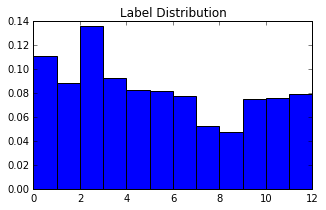

In [171]:
print 'Labels: ', set([h.label for h in ada.H])

label_distri = np.bincount([h.label for h in ada.H], minlength=n_class)
plt.figure(figsize=(5, 3))
plt.title('Label Distribution')
plt.bar(np.arange(0, n_class), label_distri*1.0/np.sum(label_distri), width=1)

In [172]:
n_clf = len(ada.H)
beta_sum = np.zeros((n_class,1))
h_tp_sum = np.zeros((n_class,1))
h_sum = np.zeros((n_class,1))
for h in ada.H:
    beta_sum[h.label] += math.log(1.0/h.beta)
    h_tp_sum[h.label] += h.label_confidences[h.label]*1.0/n_clf #Correctly predicted
    h_sum += h.label_confidences.reshape((n_class,1))*1.0/n_clf
h_tp_sum = h_tp_sum/h_sum
for i,j,k,l in zip(xrange(n_class), beta_sum, h_tp_sum, h_sum) :
    print i,j,k,l

0 [ 12.24224236] [ 0.17083163] [ 0.51947223]
1 [ 11.44940287] [ 0.14211886] [ 0.41178974]
2 [ 11.00076082] [ 0.39912005] [ 0.33858268]
3 [ 12.07292093] [ 0.14564644] [ 0.40327729]
4 [ 10.99395472] [ 0.11957052] [ 0.43605022]
5 [ 8.65663186] [ 0.13869299] [ 0.4526495]
6 [ 10.17905232] [ 0.14338429] [ 0.40370292]
7 [ 6.74648676] [ 0.10402145] [ 0.39689296]
8 [ 6.29871134] [ 0.10312862] [ 0.36731219]
9 [ 10.85595643] [ 0.14657329] [ 0.42540966]
10 [ 10.79042483] [ 0.17764579] [ 0.39412641]
11 [ 10.85738901] [ 0.12357414] [ 0.44775484]


In [173]:
# Predict train

t = time.time()
staged_pred_y = ada.predict(train_X, train_y, train_kernel)
sys.stderr.write('Test time: %f seconds\n' % (time.time() - t)) # ~ 12s / 12k training data

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:132: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Test time: 2.354358 seconds


Correct predictions:  1838


Label 0:  211
Labels:  set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])


<Container object of 12 artists>

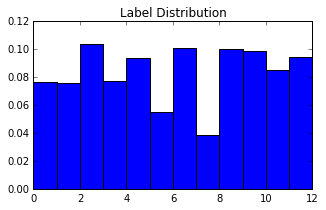

In [174]:
final_y = staged_pred_y[-1]
print 'Label 0: ', np.sum(final_y==0)
print 'Labels: ', set(final_y)

label_distri = np.bincount(final_y, minlength=n_class)
plt.figure(figsize=(5, 3))
plt.title('Label Distribution')
plt.bar(np.arange(0, n_class), label_distri*1.0/np.sum(label_distri), width=1)
        

In [175]:
# Predict test

t = time.time()
staged_pred_y_test = ada.predict(test_X, test_y)
sys.stderr.write('Test time: %f seconds\n' % (time.time() - t)) # ~ 12s / 12k training data

Test kernel shape:  (4699, 691)
Correct predictions:  373


Test time: 59.193663 seconds


Label 0:  53
Labels:  set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])


<Container object of 12 artists>

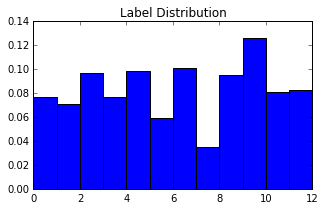

In [176]:
final_y = staged_pred_y_test[-1]
print 'Label 0: ', np.sum(final_y==0)
print 'Labels: ', set(final_y)

label_distri = np.bincount(final_y, minlength=n_class)
plt.figure(figsize=(5, 3))
plt.title('Label Distribution')
plt.bar(np.arange(0, n_class), label_distri*1.0/np.sum(label_distri), width=1)

In [177]:
for h in ada.H[:10]:
    print train_kernel[h.center_index,h.neighbor_indices[:5]]

[ 1.          0.40125112  0.39542303  0.38866662  0.38410609]
[ 1.          0.34713568  0.34076685  0.33957087  0.33668342]
[ 1.          0.3424358   0.33118144  0.32753201  0.32316167]
[ 1.          0.24492945  0.2388814   0.2364106   0.22706422]
[ 1.          0.37778563  0.35342299  0.35243522  0.3497076 ]
[ 1.          0.36818317  0.362683    0.36167548  0.35923578]
[ 1.          0.35172129  0.35133824  0.3506735   0.34926138]
[ 1.          0.42176871  0.32628483  0.32552643  0.32403357]
[ 1.          0.4047619   0.38888889  0.33333333  0.33333333]
[ 1.          0.31987578  0.30349531  0.29951691  0.28049517]


In [178]:
# Calculate true positive and abstain rate

# train_tp=[]
train_acc=[]
train_werr=[]
train_abstain_rate = []
n_training = staged_pred_y.shape[1]
for t, pred_y in enumerate(staged_pred_y):
    n_abstain = np.sum(pred_y==0)
#     n_tp_total = np.sum(pred_y!=0) if np.sum(pred_y!=0) else 1.0
#     n_tp_correct = np.sum(np.logical_and(pred_y!=0,pred_y==train_y))
    n_correct = np.sum(pred_y==train_y)
#     train_tp.append(1.0 * n_tp_correct / n_tp_total)
    train_acc.append(1.0 * n_correct / n_training)
    train_abstain_rate.append(1.0 * n_abstain / n_training)
    train_werr.append(np.sum((pred_y!=train_y)*ada.H[t].D))
    
# test_tp=[]
test_acc=[]
test_abstain_rate = []
n_testing = staged_pred_y_test.shape[1]
for pred_y in staged_pred_y_test:
    n_abstain = np.sum(pred_y==0)
#     n_tp_total = np.sum(pred_y!=0) if np.sum(pred_y!=0) else 1.0
#     n_tp_correct = np.sum(np.logical_and(pred_y!=0,pred_y==test_y))
    n_correct = np.sum(pred_y==test_y)
#     test_tp.append(1.0 * n_tp_correct / n_tp_total)
    test_acc.append(1.0 * n_correct / n_testing)
    test_abstain_rate.append(1.0 * n_abstain / n_testing)
    
print 'Training: ', n_training
print 'Final Accuracy: ', train_acc[-1]
print 'Testing: ', n_testing
print 'Final Accuracy: ', test_acc[-1]

Training:  2763
Final Accuracy:  0.665218964893
Testing:  691
Final Accuracy:  0.53979739508


In [179]:
n_class = len(labels)
n_clf = len(ada.H)

# Pseudo loss
p_loss = []
d_var = []
q_var = []
for h in ada.H:
    p_loss.append(h.pseudo_err)
    d_var.append(h.d_var)
    q_var.append(h.max_q_var)

# Pseudo loss bound
p_loss_bound = np.array(p_loss)
p_loss_bound = np.power(p_loss_bound * (np.ones(p_loss_bound.shape)-p_loss_bound), 0.5)
p_loss_bound = np.cumprod(p_loss_bound)
p_loss_bound = (n_class-1) * np.power(2*np.ones(p_loss_bound.shape),np.array(xrange(1,n_clf+1))) * p_loss_bound

print [p[0] for p in p_loss[-10:]]
print p_loss_bound[-10:]

print train_werr[-10:]

[0.49528076795885978, 0.49609470011318457, 0.49950687373838953, 0.49631899207180885, 0.49384599687760533, 0.49661041506507864, 0.49530226312326003, 0.49525507703770238, 0.49324805402171784, 0.49257081976073219]
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
[0.48487992169018856, 0.48368494867136413, 0.48360918420458188, 0.48382533530993127, 0.48453603991322575, 0.48452147850923583, 0.48410239909191366, 0.48400030667036475, 0.48371058265898292, 0.48373928803362398]


/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: overflow encountered in power
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: overflow encountered in multiply
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply


In [180]:
# w_var = []
# for w in ada.W_staged:
#     w_var.append(np.mean(np.var(w, axis=1)))

# plt.figure(figsize=(10,5));

# plt.title("W");
# plt.xlabel("W");
# plt.ylabel("Percentage");
# plt.plot(xrange(len(w_var)), w_var);
# #     plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);

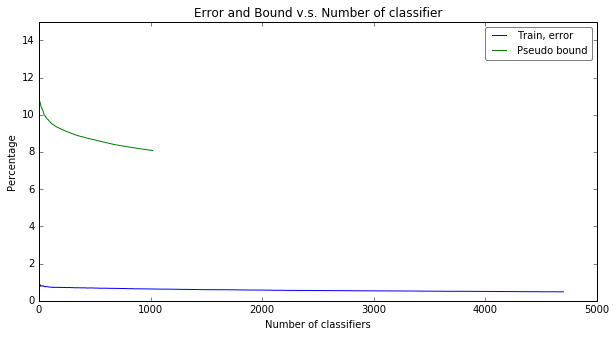

In [181]:
plt.figure(figsize=(10,5));

plt.title("Error and Bound v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage");
plt.ylim([0.0, 15.0]);
plt.plot(range(1, n_clf + 1), train_werr, label='Train, error');
plt.plot(range(1, n_clf + 1), p_loss_bound, label='Pseudo bound');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);

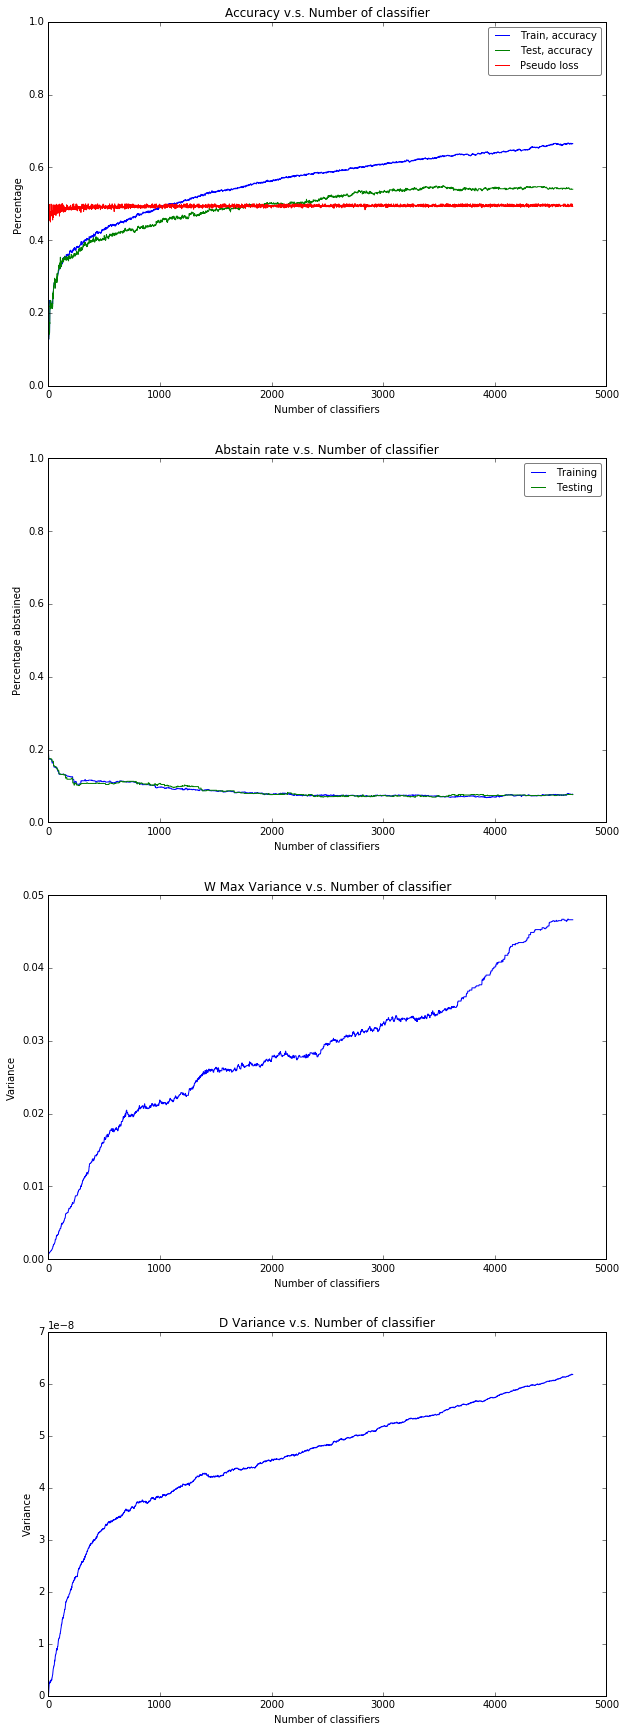

In [182]:
# Plot true positive and abstain rate

n_clf = len(ada.H);
plt.figure(figsize=(10,30));
plt.subplot(411);
plt.title("Accuracy v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage");
plt.ylim([0.0, 1.0]);
# plt.plot(range(1, n_clf + 1), train_tp, label='Train, true positive');
plt.plot(range(1, n_clf + 1), train_acc, label='Train, accuracy');
# plt.plot(range(1, n_clf + 1), test_tp, label='Test, true positive');
plt.plot(range(1, n_clf + 1), test_acc, label='Test, accuracy');
plt.plot(range(1, n_clf + 1), p_loss, label='Pseudo loss');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
# plt.hlines(0.60, 0, n_clf, linestyles=':', color='grey');
# plt.hlines(0.25, 0, n_clf, linestyles=':', color='grey');

plt.subplot(412);
plt.title("Abstain rate v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage abstained");
plt.ylim([0.0, 1.0]);
plt.plot(range(1, n_clf + 1), train_abstain_rate, label='Training');
plt.plot(range(1, n_clf + 1), test_abstain_rate, label='Testing');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
# plt.hlines(0.58, 0, n_clf, linestyles=':', color='grey');

plt.subplot(413);
plt.title("W Max Variance v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Variance");
# plt.ylim([0.0, max(q_var)]);
plt.plot(range(1, n_clf + 1), q_var, label='Q');
# plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
# plt.hlines(0.58, 0, n_clf, linestyles=':', color='grey');

plt.subplot(414);
plt.title("D Variance v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Variance");
# plt.ylim([0.0, max(d_var)]);
plt.plot(range(1, n_clf + 1), d_var, label='D');
# plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
# plt.hlines(0.58, 0, n_clf, linestyles=':', color='grey');



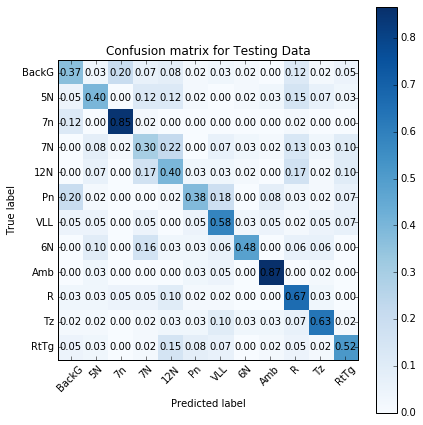

In [183]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if cm.dtype.type is np.int_:
        fmt = '%d'
    else:
        fmt = '%.2f'
    
    for x in xrange(len(labels)):
        for y in xrange(len(labels)):
            if not np.isnan(cm[y,x]):
                plt.text(
                    x,y,
                   fmt % cm[y,x],  
                   horizontalalignment='center',
                   verticalalignment='center');

cm_test = confusion_matrix(test_y, staged_pred_y_test[-1]);
cm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis];
plot_confusion_matrix(cm_test, labels, 'Confusion matrix for Testing Data');

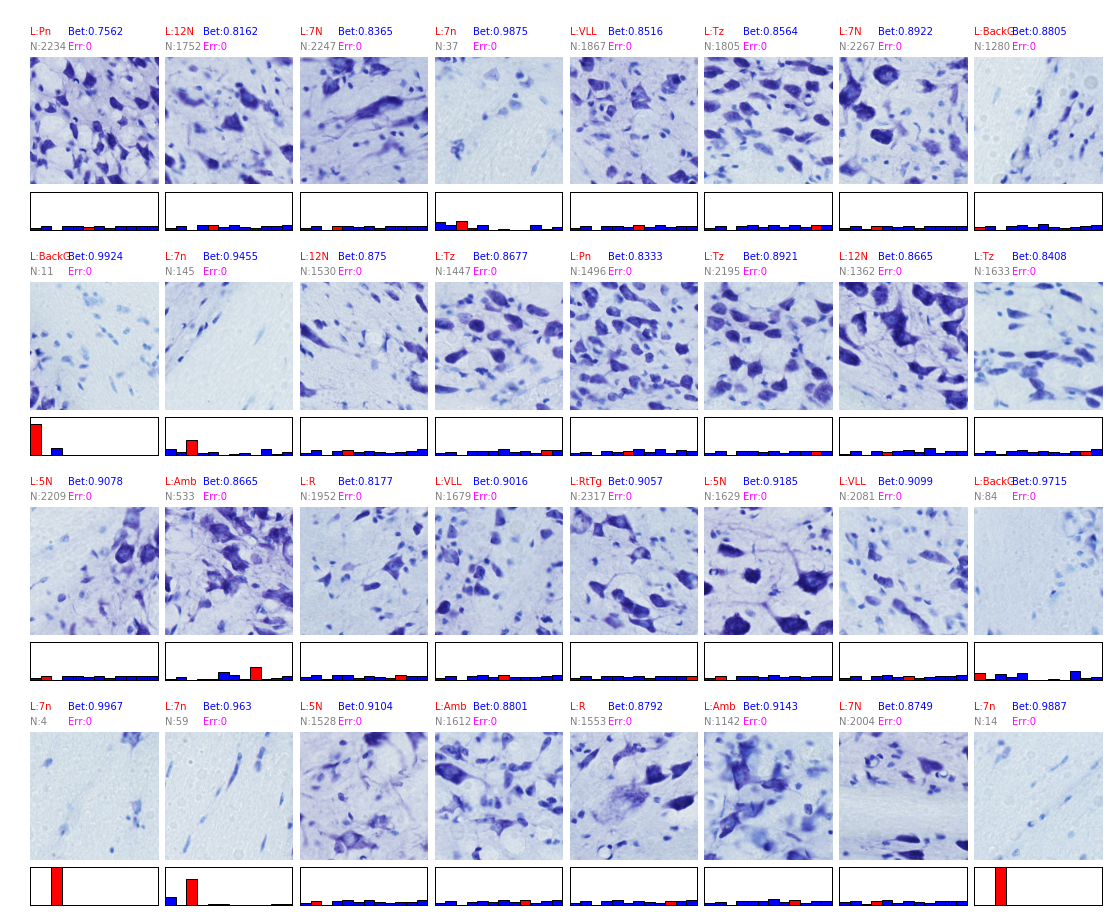

In [184]:
# Example hyperspheres

# for i in xrange(n_class):
#     print ada.H[i].label_distribution

subplot_width = 2.4
subplot_height = 4
fig_row = 4
fig_col = 8
plt.figure(figsize=(subplot_width * fig_col, subplot_height * fig_row))
plt.title('Information of hypersphere: (label, alpha, radius, number of examples)')
for row in range(0, fig_row):
    for col in range(0, fig_col):
        i = row * fig_col + col
        ax0 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row, 3 * col), colspan=3)
        ax0.text(0.0, 0.4, 'L:{}'.format(labels[ada.H[i].label]), fontsize=10, color='red')
        ax0.text(0.0, 0.0, 'N:{}'.format(ada.H[i].radius), fontsize=10, color='grey')
#         print ada.H[i].beta, float(ada.H[i].beta), ada.H[i].unweighted_err, float(ada.H[i].unweighted_err)
        ax0.text(0.3, 0.4, 'Bet:{:.4g}'.format(float(ada.H[i].beta)), fontsize=10, color='blue')
        ax0.text(0.3, 0.0, 'Err:{:.4g}'.format(float(ada.H[i].unweighted_err)), fontsize=10, color='magenta')
#         ax0.text(0.3, 0.0, 'Err:{:.2f}({:.2f})'.format(ada.H[i].unweighted_err, ada.H[i].weighted_err), fontsize=10, color='magenta');
#         ax0.text(0.6, 0.4, 'Uw.A:{:.2f}'.format(ada.H[i].unweighted_acc), fontsize=10, color='magenta');
        ax0.axison=False
        
        img=imread(train_fnames[ada.H[i].center_index])
        ax1 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row + 1, 3 * col), rowspan=3, colspan=3)
        ax1.imshow(img, cmap=plt.cm.gray)
        ax1.axis('off')
        
        ax2 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row + 4, 3 * col), colspan=3)
        ax2bar = ax2.bar(np.arange(0, n_class), ada.H[i].label_distribution*1.0/sum(ada.H[i].label_distribution), width=1)
        ax2bar[ada.H[i].label].set_color('red')
        ax2bar[ada.H[i].label].set_edgecolor('black')
        ax2.axes.get_yaxis().set_visible(False)
        ax2.axes.get_xaxis().set_visible(False)
        ax2.axes.set_ylim([0.0, 1.0]) #HACK

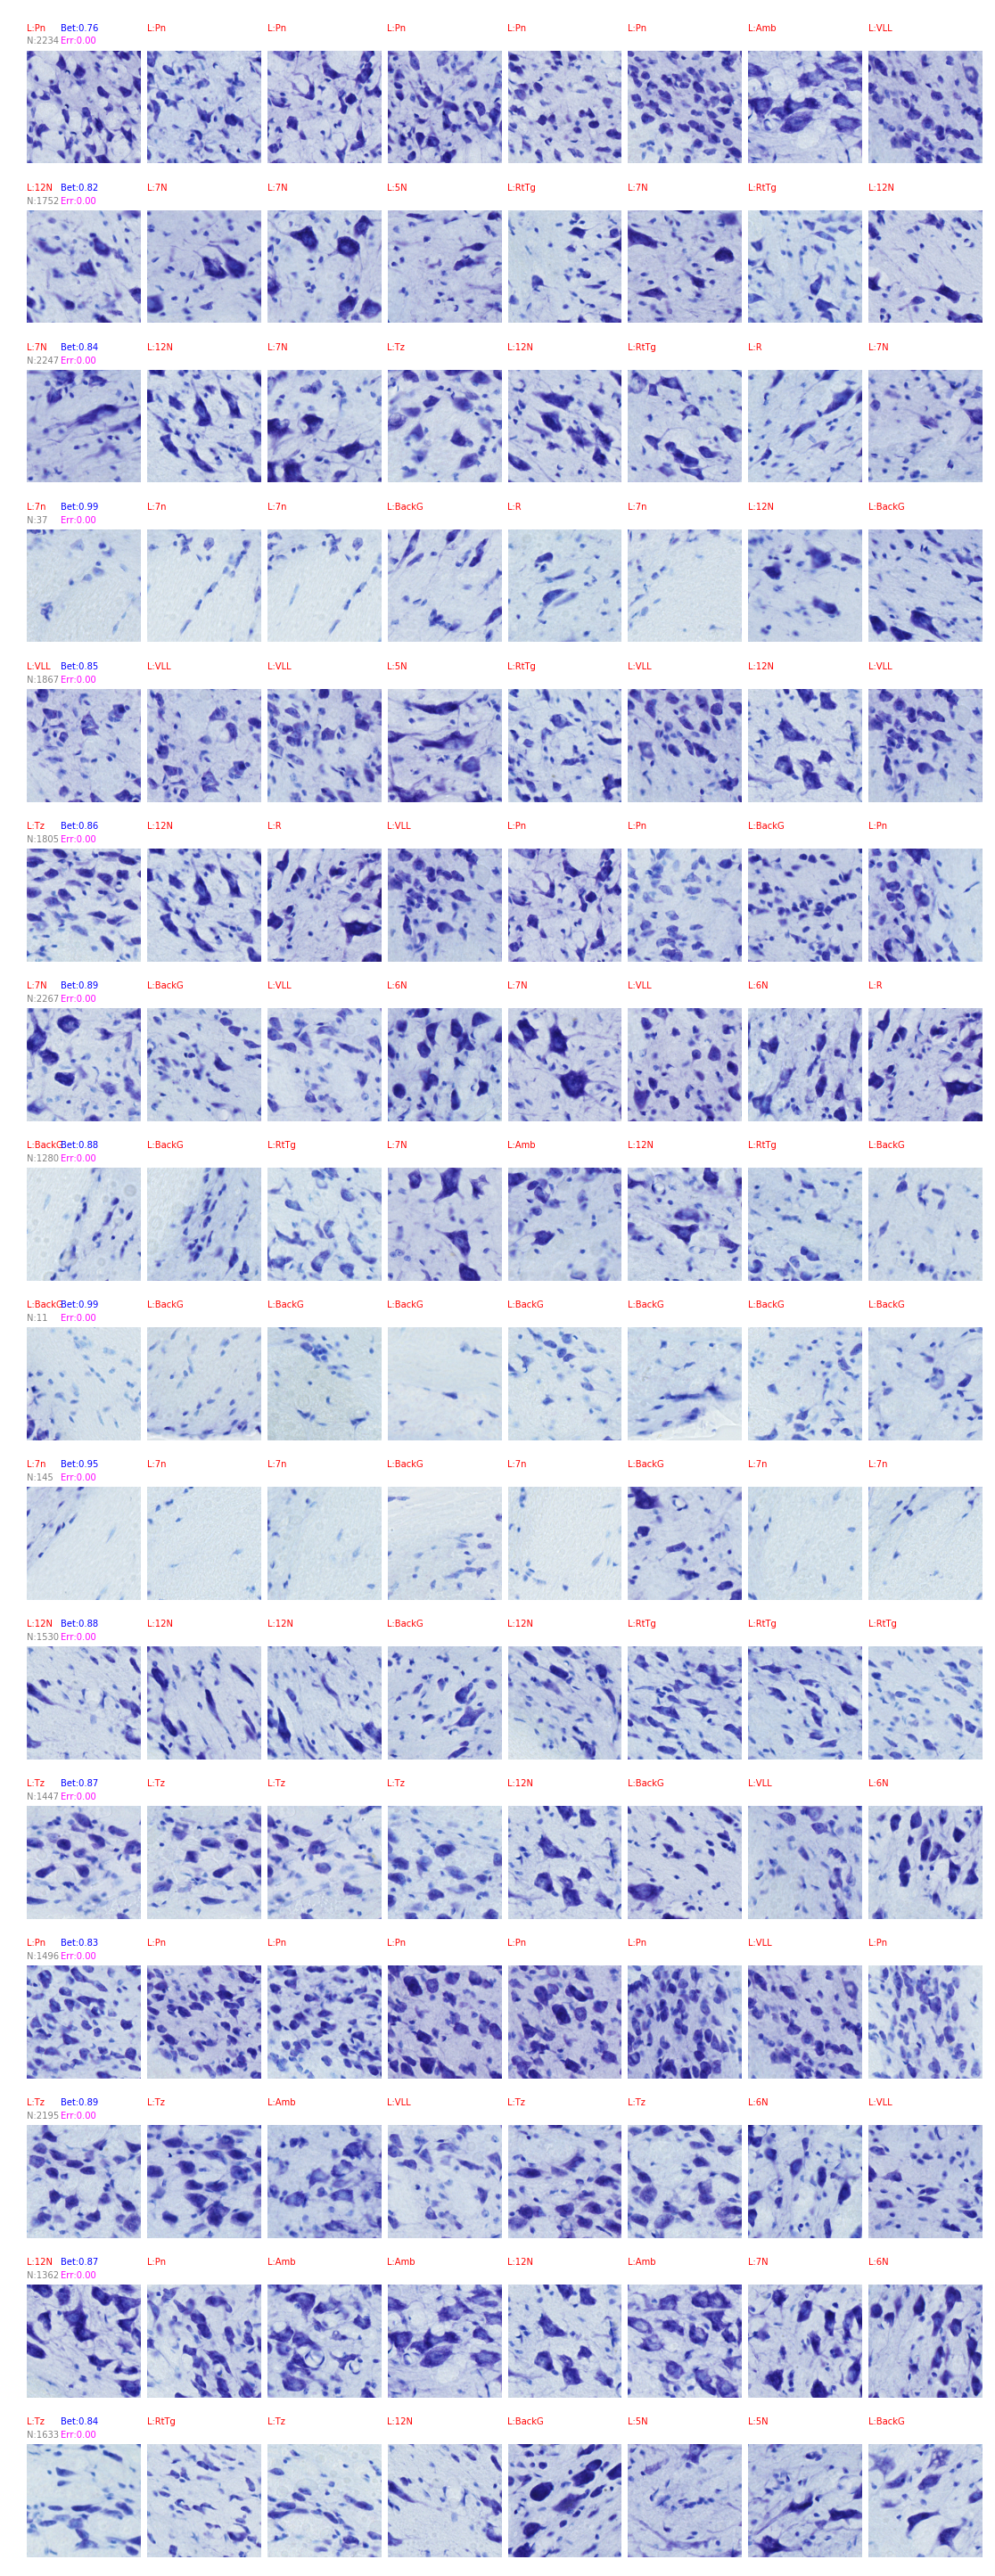

In [185]:
# Example hypersphere centers and their closest neighbors

subplot_width = 2.4;
subplot_height = 3.2;
fig_row = 16;
fig_col = 8;
plt.figure(figsize=(subplot_width * fig_col, subplot_height * fig_row));
for h in xrange(fig_row):
    for n in xrange(fig_col):
        ax0 = plt.subplot2grid((4 * fig_row, 3 * fig_col), (4 * h, 3 * n), colspan=3);
        
        if n==0:
            ax0.text(0.0, 0.4, 'L:{}'.format(labels[ada.H[h].label]), fontsize=10, color='red');
            ax0.text(0.0, 0.0, 'N:{}'.format(ada.H[h].radius), fontsize=10, color='grey');
            ax0.text(0.3, 0.4, 'Bet:{:.2f}'.format(float(ada.H[h].beta)), fontsize=10, color='blue');
            ax0.text(0.3, 0.0, 'Err:{:.2f}'.format(float(ada.H[h].unweighted_err)), fontsize=10, color='magenta');
#             ax0.text(0.3, 0.0, 'Err:{:.2f}({:.2f})'.format(ada.H[h].unweighted_err, ada.H[h].weighted_err), fontsize=10, color='magenta');
#             ax0.text(0.3, 0.4, 'A:{:.2f}'.format(ada.H[h].alpha), fontsize=10, color='blue');
#             ax0.text(0.6, 0.4, 'Uw.A:{:.2f}'.format(ada.H[h].unweighted_acc), fontsize=10, color='magenta');
        else:
            ax0.text(0.0, 0.4, 'L:{}'.format(labels[int(train_y[ada.H[h].neighbor_indices[n]])]), fontsize=10, color='red');
        ax0.axison=False;
        
        img=imread(train_fnames[ada.H[h].neighbor_indices[n]]);
        ax1 = plt.subplot2grid((4 * fig_row, 3 * fig_col), (4 * h + 1, 3 * n), rowspan=3, colspan=3);
        ax1.imshow(img, cmap=plt.cm.gray);
        ax1.axis('off');

In [186]:
# # Example hypersphere centers and their closest neighbors

# h_count = 0
# subplot_width = 2.4;
# subplot_height = 3.2;
# fig_row = 16;
# fig_col = 8;
# plt.figure(figsize=(subplot_width * fig_col, subplot_height * fig_row));

# for h in xrange(fig_row):
#     for n in xrange(fig_col):
#         ax0 = plt.subplot2grid((4 * fig_row, 3 * fig_col), (4 * h, 3 * n), colspan=3);
        
#         while ada.H[h_count].label!=11:
#             h_count += 1
        
#         print 'h_count: ', h_count
#         print 'D(center): ', ada.H[h_count].D[ada.H[h_count].center_index]
#         print 'D_max: ', np.max(ada.H[h_count].D)
#         print 'D_min: ', np.min(ada.H[h_count].D)
        
#         if n==0:
# #             print ada.H[h_count].beta
#             ax0.text(0.0, 0.4, 'L:{}'.format(labels[ada.H[h_count].label]), fontsize=10, color='red');
#             ax0.text(0.0, 0.0, 'N:{}'.format(ada.H[h_count].radius), fontsize=10, color='grey');
#             ax0.text(0.3, 0.4, 'Bet:{:.2f}'.format(float(ada.H[h_count].beta)), fontsize=10, color='blue');
#             ax0.text(0.3, 0.0, 'Err:{:.2f}'.format(float(ada.H[h_count].unweighted_err)), fontsize=10, color='magenta');
# #             ax0.text(0.3, 0.0, 'Err:{:.2f}({:.2f})'.format(ada.H[h].unweighted_err, ada.H[h].weighted_err), fontsize=10, color='magenta');
# #             ax0.text(0.3, 0.4, 'A:{:.2f}'.format(ada.H[h].alpha), fontsize=10, color='blue');
# #             ax0.text(0.6, 0.4, 'Uw.A:{:.2f}'.format(ada.H[h].unweighted_acc), fontsize=10, color='magenta');
#         else:
#             ax0.text(0.0, 0.4, 'L:{}'.format(labels[int(train_y[ada.H[h_count].neighbor_indices[n]])]), fontsize=10, color='red');
#         ax0.axison=False;
        
#         img=imread(train_fnames[ada.H[h_count].neighbor_indices[n]]);
#         ax1 = plt.subplot2grid((4 * fig_row, 3 * fig_col), (4 * h + 1, 3 * n), rowspan=3, colspan=3);
#         ax1.imshow(img, cmap=plt.cm.gray);
#         ax1.axis('off');
        
#         h_count += 1